<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S75_drone_planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q -U gtbook

In [2]:
import torch
import numpy as np
import plotly.subplots as pls
import plotly.graph_objects as go
import plotly.express as px

import gtsam
from gtsam import Point2
import gtbook.drone as drone

try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Trajectory Optimization

> We can use factor graphs to optimize over future trajectories, as well.

<img src="Figures7/S75-Autonomous_camera_drone-05.jpg"  alt="Splash image with steampunk drone in aggressive maneuver" width="40%" align=center style="vertical-align:middle;margin:10px 0px">


In the previous section we saw how do use factor graphs for visual SLAM and structure from motion. These perception algorithms are typically run after we have gathered some visual information, and inform us about what happened in the past. But how can we plan for the future? 

We already saw that RRTs are useful paradigm to plan in a continuous, potentially high dimensional state space. However, RRT's are not concerned with optimality. They aim for feasible paths, where sometimes feasibility means "collision-free" and sometimes it includes honoring the system dynamics. But if we want to achieve optimal trajectories in terms of time to goal, best use of energy, or minimum distance, we need to turn to other methods.

In this section we will discuss optimization methods for control. In particular, we will use **trajectory optimization**, to minimize the cost associated with the trajectory that we would like to execute in the future. These costs can be associated with staying away from obstacles, or other desirable properties like minimizing power consumption to preserve battery life. RRTs and trajectory optimization can be combined, where RRT finds a good "broad strokes" trajectory, and trajectory optimization smooths out and fine-tunes the final trajectory.

We explain trajectory optimization using a very simple problem: how to get from point A to point B. This seems like an easy problem, as we all know the answer should be a straight line, right? But, it is not as easy for drones, as we have to account for the drone's attitude, and we might have to accelerate and decelerate at the start and end points. Come to think of it, maybe we are already flying at a certain velocity at point A, and want to have a certain velocity at point B! Clearly, this is not as easy as it appears.

Below we go about it in steps:
- We explain how finding an optimal *path* is all we need to do at first.
- We discuss how to represent environments with obstacles to avoid: maps.
- We introduce factor graphs to find an optimal path in those maps.
- A path solution can be converted into a *trajectory* using interpolation in time.

We then show the broad outlines of building a simple cascaded controller able to execute these trajectories. Using the drone kinematics and dynamics models from Section 7.2, we then show how to implement these controllers and evaluate them in simulation.

## Optimizing for Position

> Position is all we need.

It turns out we can optimize for position only, without worrying about attitude, at least at first. This is not a trivial statement, and it is also very fortunate. Let us assume that we want to fly in a forest, full of trees, and we want a trajectory for the drone avoid the trees. A quadrotor-style drone trajectory has the potential to be rather complicated: the drone lives in the 6DOF space of position (3DOF) and attitude (3DOF). And we know from Section 7.2 that attitude will *affect* position: if we pitch or role, that will affect our velocity, and that will integrate into position. That very mechanism is also a source of complexity: a drone is *under-actuated*: we cannot directly control the 6DOF, we have to do it through the action only four rotors. It seems like a very complex problem indeed.

When given a continuous **path** of positions to get us from A to B, we can obtain the pitch, roll, and thrust trajectories to realize it. A path does not include the notion of time, i.e., it only defines *where* the drone as a function of a 1D parameter $s$. We do insist that no teleportation occurs, i.e., the path needs to be continuous. A **trajectory** on the other hand adds the notion of velocity and hence time, but we will worry about that later.

To find a suitable translational trajectory that avoids obstacles, we will use optimization. There are many ways one can do this, some better than others, but here strive for simplicity: we discretize the time interval in which we expect to fly and solve for a set of corresponding set of positions over time that satisfy our objectives. These objectives can include:

- a desired starting position (and velocity, if so desired);
- a desired goal position (and velocity, if desired);
- a desired distance from the closest obstacle at any time;
- a smoothness objective that bounds our velocity and/or acceleration.

If these objectives are in conflict, we can assign them weights such that we trade off some against others. Constrained optimization techniques allow to set hard constraints and/or bounds, but we do not use those here. Instead, we opt for a simple non-linear least squares scheme that minimizes the following objective:

$$
X^* = \arg \min \sum_{k=1}^K \phi_k(X_k)^2  + \sum_{k=1}^{K-1} \psi_k(X_k, X_{k+1})^2
$$

where $X_k$ is the position at time, and $\phi_k(X_k)$ and $\psi_k(X_k, X_{k+1})$ are unary and binary objectives, respectively, that we want to minimize. Desired start and goal, as well as obstacle avoidance are examples of unary objectives, while smoothness is a binary objective, as it evaluates the distance/velocity between successive positions.

It will not come as any surprise that we can also use factor graph optimization to find our optimal trajectories. The objective above is exactly the expression of a nonlinear factor graph, except that the factors now derive from objectives we want to minimize, rather than measurement errors. In the next section we work in detail how to do so.

## Occupancy and Cost Maps

> Maps with costs to minimize.

A very popular approach to represent environments with different obstacles is to use an **occupancy map**. An occupancy map is essentially a 2D array of cells, each representing the environment at a certain resolution (for example, 10 cm by 10 cm). Each cell in this map contains a probability for the presence of an obstacle. This concept is further extendable to distinguish between various types of obstacles, each with different levels of lethality. This extended version can then be transformed into a **cost map**, where areas with less hazardous obstacles (like tall grass) are considered less costly compared to more dangerous ones (like flying into a tree). For our purposes, we will start directly with cost maps instead of creating true occupancy maps.

To illustrate, let us consider creating a simple example cost map. In the `gtbook/drone` library, we have a function named `create_random_map`. This function requires as parameters the width $W$, height $H$, and the number of obstacles to create a random arrangement of obstacles within the map. Width and height are given in meters, and the resolution is hardcoded at 10 cm. An optional parameter is a random seed, which allows for the reproduction of the exact experiment setup. The following code snippet demonstrates how to generate a random map with 50 obstacles using a random seed of 42:

In [3]:
# Create a random cost map
W, H = 30, 10  # 30m x 10m
cost_map = drone.create_random_map(W, H, num_obstacles=50, seed=7)

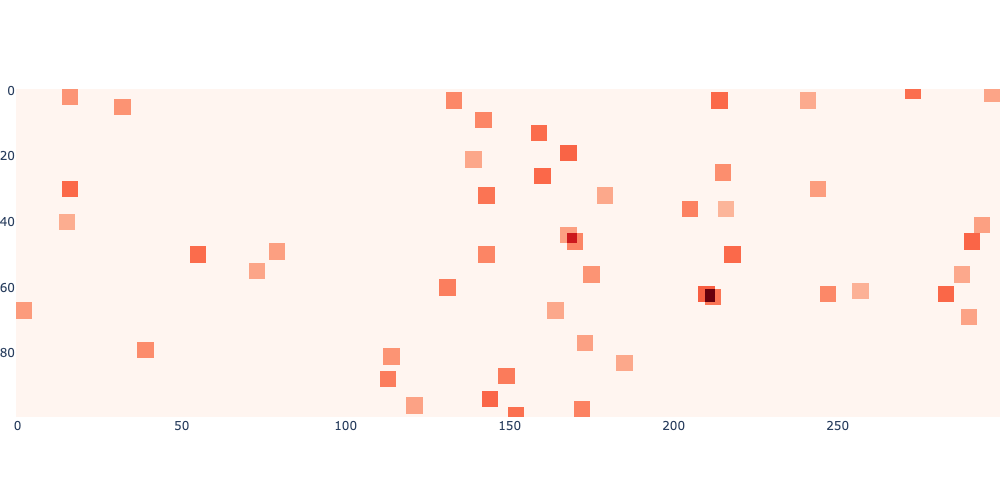

In [4]:
#| caption: Cost map with randomly generated obstacles, at 10cm resolution.
#| label: fig:obstacles
fig = px.imshow(cost_map, color_continuous_scale='Reds')
fig.update_layout(coloraxis_showscale=False, margin=dict(l=0, r=0, t=0, b=0), width=1000)
fig.show()

To create differentiable factors $\phi_k(X_k)$ that avoid high cost areas, we can smooth the cost map with a differentiable kernel, like a Gaussian. The cost map above is a torch tensor, representing a grayscale image 100 pixels tall and 300 pixels wide. Convolving an image with a kernel is relatively easy in pytorch, though we need to juggle some tensor dimensions because by convention, `conv2d` operates on $\text{batch} \times \text{channel} \times \text{height} \times \text{width}$ tensors:

In [5]:
sigma = 0.5  # 0.5m standard deviation for the Gaussian kernel
K = 21 # 21x21 kernel is big enough to accommodate that standard deviation 
kernel = drone.gaussian_kernel(sigma*10, K) # multiply by 10 as map is 10cm resolution
batch = cost_map[None, None, ...]  # Add batch and channel dimensions
blurred = torch.conv2d(batch, kernel, padding='same')[0, 0, ...]

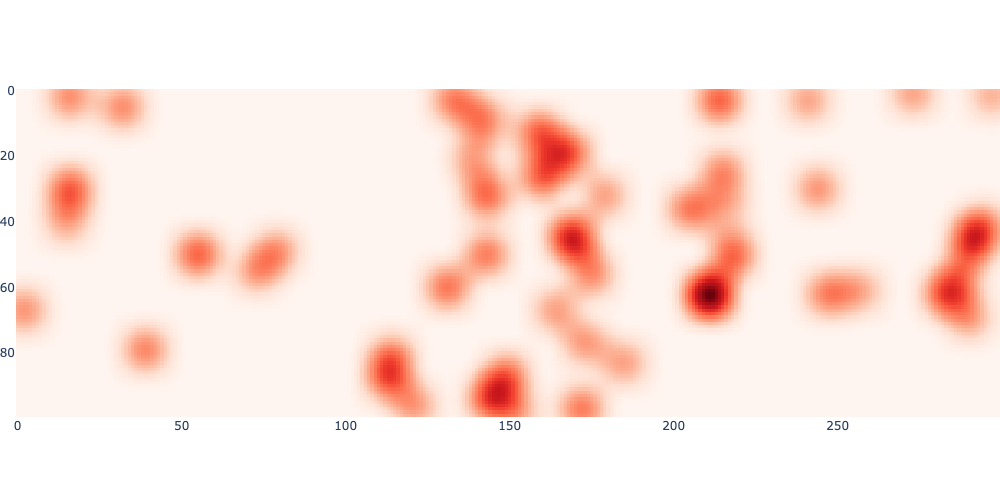

In [6]:
#| caption: Cost map blurred with 0.5 meter Gaussian kernel.
#| label: fig:blurred
fig = px.imshow(blurred, color_continuous_scale='Reds')
fig.update_layout(coloraxis_showscale=False, margin=dict(l=0, r=0, t=0, b=0), width=1000)
fig.show()

To get truly differentiable factors, however, it is better to construct a custom Gaussian kernel at the exact location we want to evaluate the cost. Remember we are trying to minimize a trajectory, by moving around a set of positions $X_k$ at discrete time stamps $t_k$. In non-linear optimization, the story is always the same: evaluate the cost *and* its derivatives at a current guess, and then use the derivatives to move to a lower cost solution. However, if we smooth a discretized cost map, the result is still discretized, however smooth it looks to us. To get the *exact* value of the cost, and its derivatives, we can create a Gaussian kernel centered *exactly* at our current *continuous* position.

The function `gaussian_filter` does just that: it evaluates a single Gaussian kernel operator given a standard deviation, a continuous map location, and the map to operate on. The code below shows that this gives the exact same result as a lookup in the blurred image when given an integer coordinate, but it *also* works for non-integer coordinates:

In [7]:
xy = Point2(7.5, 5.3) # point in map, in meters
uv = 10*xy # continuous position in image
local_result = drone.gaussian_filter(sigma*10, uv, cost_map, K)
print(f"Local cost at {xy} is {local_result:.3f}")

# When uv are at integer values, blurred image gives the same result:
assert np.allclose(local_result, blurred[int(uv[1]), int(uv[0])])

Local cost at [7.5 5.3] is 0.135


To get the derivatives we blur the vertical and horizontal gradient images, respectively. Remember that we need the derivative of the exact cost with respect to x and y, if we are to optimize over those positions. Because convolution is a linear operation, we can take the derivative of the Gaussian kernel with respect to x and y, *or* we can apply the convolution on a derivative image. We choose the latter, by first using the Sobel operator we encountered in Section 5.4 to create gradient images: 

In [8]:
# Compute gradients:
sobel_u, sobel_v = drone.sobel_kernels()
grad_u = torch.conv2d(batch, sobel_u, padding='same')[0,0,...]
grad_v = torch.conv2d(batch, sobel_v, padding='same')[0,0,...]

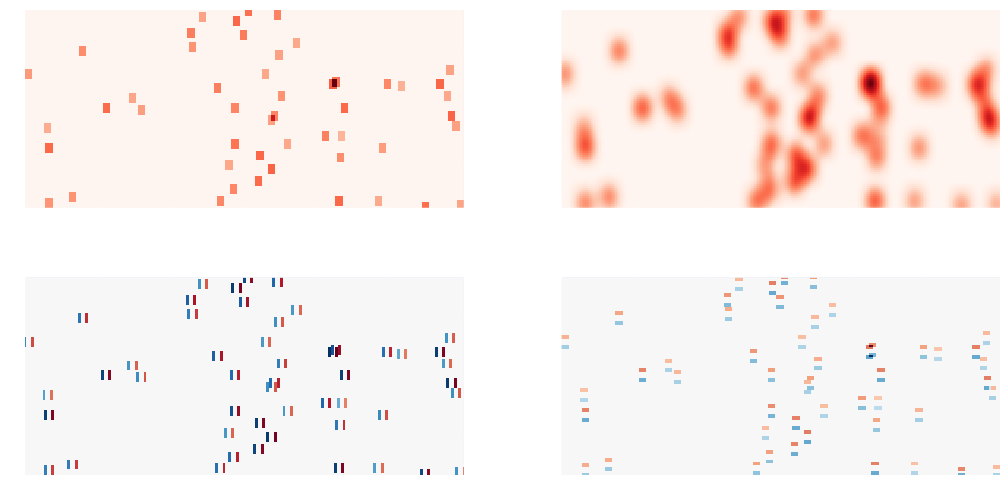

In [9]:
#| caption: Obstacle cost map, blurred cost map, and both vertical and horizontal sobel gradients.
#| label: fig:obstacles-2x2
fig = pls.make_subplots(rows=2, cols=2)
fig.add_trace(go.Heatmap(z=cost_map, colorscale='reds', showscale=False), row=1, col=1)
fig.add_trace(go.Heatmap(z=blurred, colorscale='reds', showscale=False), row=1, col=2)
fig.add_trace(go.Heatmap(z=grad_u, colorscale='rdbu', showscale=False), row=2, col=1)
fig.add_trace(go.Heatmap(z=grad_v, colorscale='rdbu', showscale=False), row=2, col=2)
for i in [1,2]:
    for j in [1,2]:
        fig.update_xaxes(title_text="", showticklabels=False, row=i, col=j)
        fig.update_yaxes(title_text="", showticklabels=False, row=i, col=j)
fig.update_layout(margin=dict(l=0, r=0, t=10, b=0), width=1000)
fig.show()

Figure <a href="#fig:obstacles-2x2" data-reference-type="ref" data-reference="fig:obstacles-2x2">3</a> shows both cost map and its blurred version, as well as the (un-blurred) gradient images `grad_u` and `grad_v`. We can then combined these into one rank-3 tensor and evaluate the cost *and* derivatives in one operation:

In [10]:
combined = torch.stack([cost_map, grad_u, grad_v], dim=0)
print(np.round(drone.gaussian_filter(sigma*10, uv, combined, K),3))

[ 0.135  0.004 -0.004]


## Factor Graphs for Trajectory Optimization

Now that we can evaluate cost its derivatives at any location, we can create factors. Since occupancy maps or cost maps are not built into GTSAM, we use its facility to create a custom factor from arbitrary python code. A `gtsam.CustomFactor` just has a constructor that can take an arbitrary python callback function, along with a `Key` (and a noise model). At evaluation, the callback function gets a handle to the factor and a `gtsam.Values` object, and it is supposed to do three things:

- check which variable is involved, by asking the factor;
- with that key, extract the current estimate from the passed in `Values`;
- calculate the cost, and if asked, its derivatives.

The fact that we can do this for arbitrary python code is very convenient, and is used below to create cost factors that interrogate the cost map, using our localized Gaussian filter, and if asked, its derivatives:

In [11]:
def error_func(factor: gtsam.CustomFactor, v: gtsam.Values, H: list[np.ndarray]):
    """Error function for the custom factor."""
    # Extract the Point2 variable using the key in the factor
    point = v.atPoint2(factor.keys()[0])

    uv = 10 * point # Convert to map coordinates

    if H is None:
        cost = drone.gaussian_filter(sigma * 10, uv, cost_map, K)
    else:
        # If Jacobian is needed, calculate them here:
        cost, cost_x, cost_y = drone.gaussian_filter(sigma * 10, uv, combined, K)
        H[0] = np.array([[cost_x, cost_y]])

    return np.array([cost]).astype(float)

Let us discretize the trajectory with M factors, using the keys $k\in 1...M$. We can define a start and goal point, and initialize the trajectory as straight line. Who knows, we might be lucky and hit no obstacles along the way:

In [12]:
M = 100 # Number of points
start, goal = Point2(2, 5), Point2(28, 5)
initial = gtsam.Values()
for k in range(1,M+1):
    alpha = (k-1)/(M-1)
    initial.insert(k, (1-alpha)*start + alpha*goal)

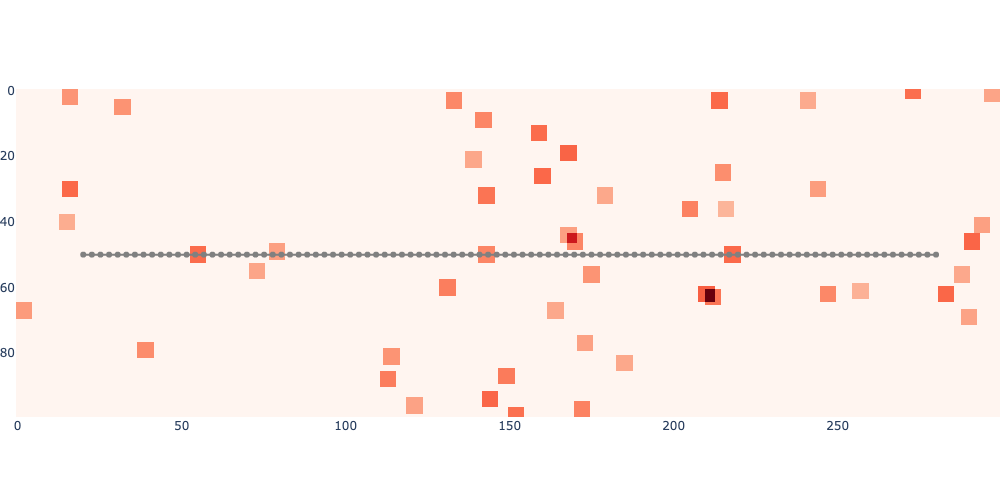

In [13]:
#| caption: Initial trajectory estimate plotted on the cost map.
#| label: fig:initial
initial_path = 10*gtsam.utilities.extractPoint2(initial)
fig = px.imshow(cost_map, color_continuous_scale='Reds')
fig.add_trace(go.Scatter(x=initial_path[:,0], y=initial_path[:,1], mode='lines+markers', line=dict(color='gray')))
fig.update_layout(coloraxis_showscale=False, showlegend=False, margin=dict(l=0, r=0, t=0, b=0), width=1000)

Plotting this trajectory on the cost map shows that we are not lucky, however: we are definitely going through some obstacles. We can immediately create all obstacle cost factors now, and evaluate the cost to conform this is not a zero-cost path. Since these factors are non-linear, we store them in a `gtsam.NonlinearFactorGraph`:

In [14]:
obstacle_factors = gtsam.NonlinearFactorGraph()
for k in range(1,M+1):
    custom_factor = gtsam.CustomFactor(None, [k], error_func)
    obstacle_factors.add(custom_factor)
print(f"Graph has {obstacle_factors.size()} factors")

Graph has 100 factors


The error profile along the trajectory clearly corresponds with the obstacles we encounter along the way. We can evaluate both the individual errors and the sum-of-squares error $\sum\psi_k(X_k)^2$ of a factor graph. The former gives us an error profile along the way, and the latter represents a loss we would like to minimize. We show the former as a bar graph below:

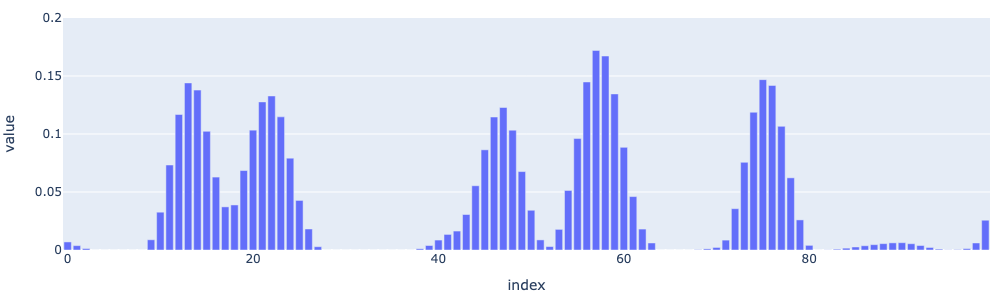

In [15]:
#| caption: Errors for the initial trajectory estimate.
#| label: fig:initial-errors
errors = -obstacle_factors.linearize(initial).jacobian()[1]
fig = px.bar(errors, labels={'x': 'Factor', 'y': 'Error'}, range_y=[0, 0.2])
fig.update_layout(coloraxis_showscale=False, showlegend=False, height=300, width=1000, margin=dict(l=10, r=10, t=10, b=10))

A complete trajectory optimization problem needs more than just obstacle factors, however. We also need to add start and goal factors, as well as smoothness factors. Start and goal factors make sure that we start at our current position, and tell our optimizer where we want to go. They can both be implemented as simple priors on the variables with keys $k=1$ and $k=100$. Smoothness factors are implemented using a `gtsam.BetweenFactor`, and make sure that we obtain a smooth, continuous trajectory.

Both types of factors are added in the code below:

In [16]:
# We start by copying the obstacle factors:
graph = gtsam.NonlinearFactorGraph()
graph.push_back(obstacle_factors)

constrained2 = gtsam.noiseModel.Constrained.All(2) # We *insist* on the start and goal points!
graph.addPriorPoint2(1, start, constrained2)
graph.addPriorPoint2(M, goal, constrained2)

# The strength of the smoothness factors is controlled by a `precision` value: higher is stronger.
# Feel free to change the precision value below and see how the optimizer behaves:
smoothness_model = gtsam.noiseModel.Isotropic.Precision(2, 0.01)
for k in range(1, M):
    graph.add(gtsam.BetweenFactorPoint2(k, k+1, gtsam.Point2(0.0, 0.0), smoothness_model))

To optimize, we use a Levenberg Marquardt non-linear optimizer. This optimizer, which we have encountered before, linearizes the factors at every iteration and takes a cautious second-order minimization step. The "cautiousness" is governed by a parameter $\lambda$ that essentially selects between gradient descent ($\lambda$ high) and a second-order Gauss-Newton step ($\lambda$ low).  In our potentially very non-linear cost landscape it is good practice to start of the optimizer with a relatively high value for $\lambda$:

In [17]:
print(f"Initial error: {graph.error(initial):.3f}")
params = gtsam.LevenbergMarquardtParams()
params.setlambdaInitial(100)
# params.setVerbosityLM("SUMMARY") # uncomment this line to see the LM progress
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()
print(f"Final error: {graph.error(result):.3f}")

Initial error: 0.236
Final error: 0.064


The optimizer is very fast, on the order of milliseconds, so it can be used in an online planner that continuously re-plans as the cost map is updated with new information. When used for flying a drone, we can execute on the initial part of the trajectory and then immediately re-plan. This scheme is known as "model-predictive" control, and is frequently used in actual autonomous vehicles and drones.

In our case, the optimizer found a very nice trajectory that navigates some tricky obstacle configurations, especially in the second half of the trajectory:

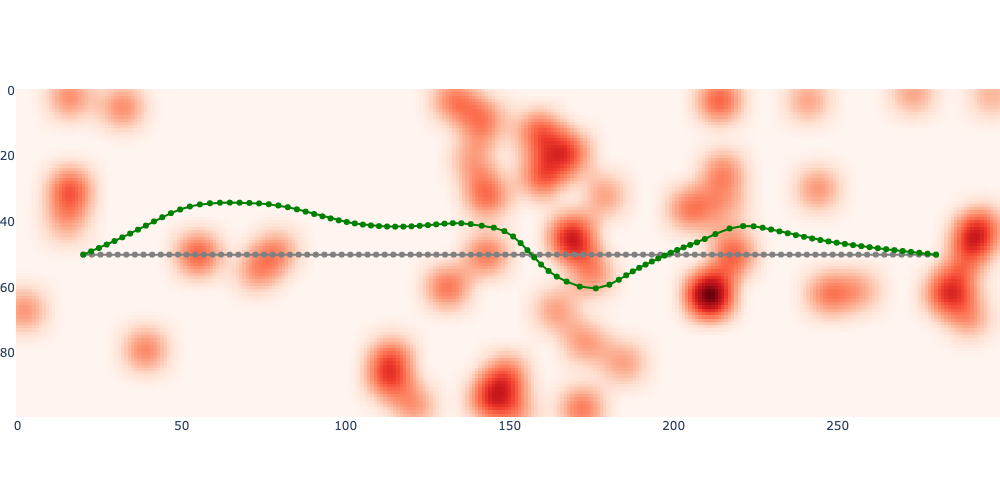

In [18]:
#| caption: Initial and final trajectories plotted on the blurred cost map.
#| label: fig:final
result_path = 10*gtsam.utilities.extractPoint2(result)
fig = px.imshow(blurred, color_continuous_scale='Reds')
fig.add_trace(go.Scatter(x=initial_path[:,0], y=initial_path[:,1], mode='lines+markers', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=result_path[:,0], y=result_path[:,1], mode='lines+markers', line=dict(color='green')))
fig.update_layout(coloraxis_showscale=False, showlegend=False, width=1000, margin=dict(l=0, r=0, t=0, b=0))

The error profile along this final trajectory is not entirely down to zero, as we have to navigate some tight obstacle configurations along the way. However, when plotted on the same scale it looks much better than for the initial trajectory:

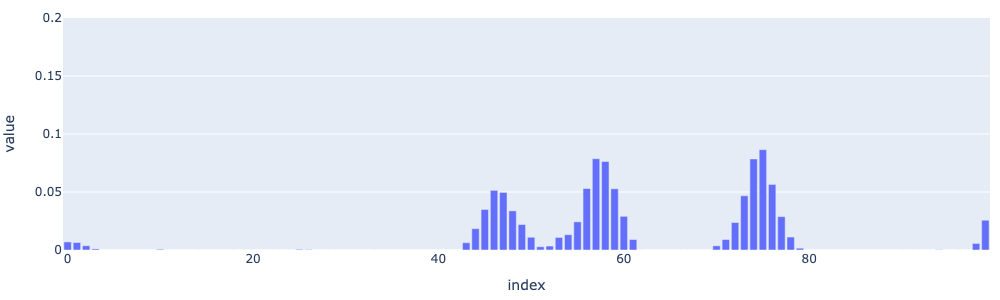

In [19]:
#| caption: Errors for the final trajectory result.
#| label: fig:final-errors
errors = -obstacle_factors.linearize(result).jacobian()[1]
fig = px.bar(errors, labels={'x': 'Factor', 'y': 'Error'}, range_y=[0, 0.2])
fig.update_layout(coloraxis_showscale=False, showlegend=False, width=1000, height=300, margin=dict(l=10, r=10, t=10, b=10))

## Smoothing

> From path to trajectory.

We need to convert an optimal path to an optimal trajectory. Here we will do so very simply by assigning a total execution time $T$ to the path. This turns our optimized path into a trajectory in time, as our uniformly spaced positions now all get an associated time $t_k$ and hence also a local velocity, acceleration, etc... 

We have to choose $T$ judiciously. We may want to go fast, but we need to make sure is is not a totally crazy trajectory: a drone can't stop on a dime or go faster than certain limits. If we choose T to be small, we are asking the drone to fly fast and we might hit thrust limits. If we choose T to be high, the drone will fly more slowly. T=20 is a good compromise in our case, as we expect the average velocity to be a bit above 1 m/s.

Once we have a 3DOF translational trajectory that is well behaved, we can "upgrade" it to a full position/attitude in two different ways: in advance, by solving a large optimization problem, or physically, in real-time, by using a tracking controller. The latter is what we will do, after obtaining a trajectory.

Even after assigning $T$, we have a need for a different representation. A discretized trajectory is not great, as we cannot obtain velocities and accelerations easily. Below we use a class `SmoothTrajectory` which takes a discretized path, a given $T$, and fits a polynomial approximation. An additional parameter is the number of control points $N$, which determines how smooth our approximation is.

We do so below in code, but before we do, we add a constant height of 1.5m. Also, we set the flag `boundaries` to True, which enforces constant velocity (zero acceleration) at the endpoints.

In [20]:
# Add height of 1.5 meters
xy = gtsam.utilities.extractPoint2(result)
path = np.hstack([xy, np.full((len(xy),1), 1.5)])

T = 20.0
smooth = drone.SmoothTrajectory(path, N=20, a=0, b=T, boundaries=True)

We can then evaluate and visualize the smoothed trajectory at *any* time t between 0 and T:

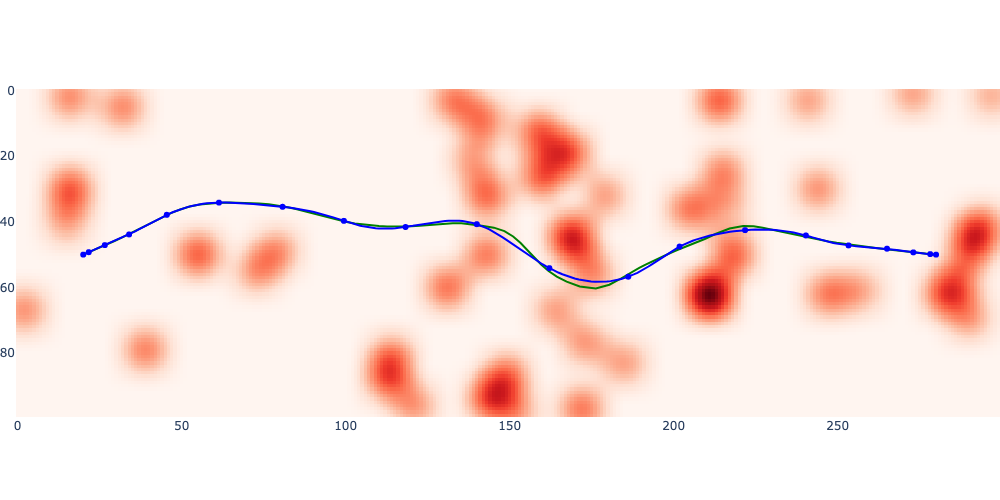

In [21]:
#| caption: Discretized and smoothed trajectory.
#| label: fig:smoothed
timestamps = np.linspace(0.0 , T, 250)
desired_rn = smooth.evaluate(timestamps) # desired trajectory in navigation frame

fig = px.imshow(blurred, color_continuous_scale='Reds')
fig.add_trace(go.Scatter(x=result_path[:,0], y=result_path[:,1], mode='lines', line=dict(color='green')))
fig.add_trace(go.Scatter(x=10*desired_rn[:,0], y=10*desired_rn[:,1], mode='lines', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=10*smooth.points[:,0], y=10*smooth.points[:,1], mode='markers', line=dict(color='blue')))
fig.update_layout(coloraxis_showscale=False, showlegend=False, margin=dict(l=0, r=0, t=0, b=0), width=1000)

Finally, it is instructive to inspect the velocity profiles as well:

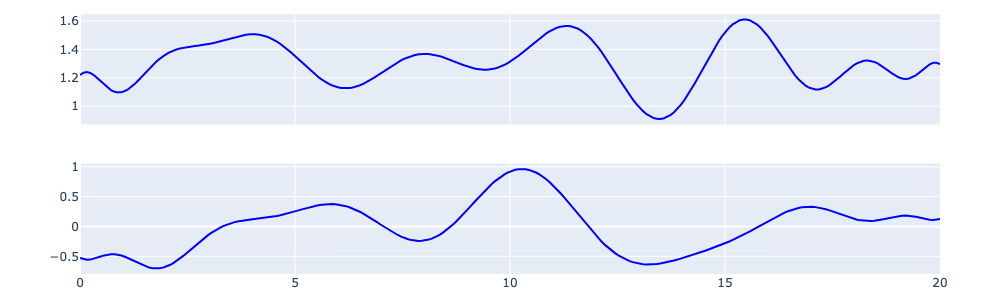

In [22]:
#| caption: smoothed trajectory as time series.
#| label: fig:smoothed-series
desired_vn = smooth.velocities(timestamps) # desired velocity in navigation frame
desired_an = smooth.accelerations(timestamps) # desired acceleration in navigation frame
fig = pls.make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(x=timestamps, y=desired_vn[:,0], mode='lines', line=dict(color='blue'), name='vx'), row=1, col=1)
fig.add_trace(go.Scatter(x=timestamps, y=desired_vn[:,1], mode='lines', line=dict(color='blue'), name='vy'), row=2, col=1)
fig.update_layout(coloraxis_showscale=False, showlegend=False, width=1000, height=300, margin=dict(l=80, r=60, t=10, b=10))

You can see that, for our chosen T=20, the drone flies at velocities between 1 and 1.6 m/s, which is what we expected for T=20.

## A Virtual Vectored Thrust

> What we want, in theory...

We control the position of the drone using a 3DOF vectored thrust input: thrust magnitude, roll, and pitch. The idea outlined here is a simplified version of the geometric controller in

> K. Gamagedara, M. Bisheban, E. Kaufman, T. Lee, "Geometric Controls of a Quadrotor UAV with Decoupled Yaw Control," in *2019 American Control Conference (ACC)*, Philadelphia, PA, USA, July 10-12, 2019.


The idea is rather simple. Remember the translational equations of motion from Section 7.2:

$$
\dot r^n = v^n \\
m \dot v ^n = R^n_b f + m g^n
$$

where $m$ is the mass. Let us concentrate on the dynamics part: we *know* the acceleration $\dot v^n_d$ we want from our planned trajectory, and gravity is a given. Hence, to make the drone do what we want, we can only hope to change the quantity $R^n_b f$. Let is call that the **vectored thrust** $T^n$, defined in the navigation frame. Then, to obtain the desired acceleration, the vectored thrust has to satisfy

$$
T^n = m \dot v^n_d - m g^n.
$$

You can think of $T^n$, which is a 3D vector, as a thrust vector that pushes the drone exactly where it needs to be. It can move the drone forwards or backwards by pitching appropriately, and left or right by rolling. But of course, at all times we need to make sure it cancels gravity as well, which explains the second term above. Even after gravity compensation, to gain or lose altitude, the thrust magnitude can be adjusted to make either happen. In control-theoretic terms, $T^n$ can be thought of as a virtual control input.

All of this is implemented in the `vectored_thrust` function below, and they are shown below that, sampled at regular intervals along our optimized trajectory.

In [23]:
# Drone parameters used below.
class Params:
    g = 9.81
    mass = 1.0
    gn = np.array([0, 0, -g]) # gravity vector in navigation frame.
    # Moment of inertia for pitch and roll, values copied from Section 7.2:
    I_xy = 4 * 0.15 * mass * 0.1**2  # All 4 motors contribute to I_xy

In [24]:
def vectored_thrust(k: int):
    """Calculate the vectored thrust at timestamp k."""
    an_d = desired_an[k] # desired acceleration in navigation frame
    return Params.mass * (an_d - Params.gn)

# now calculate all the desired thrust vectors:
print(f"desired_thrust[0] = {vectored_thrust(0)}")
print(f"desired_thrust[-1] = {vectored_thrust(-1)}")

desired_thrust[0] = [ 0.25988069 -0.34011288  9.81      ]
desired_thrust[-1] = [-0.18333472  0.19575027  9.81      ]


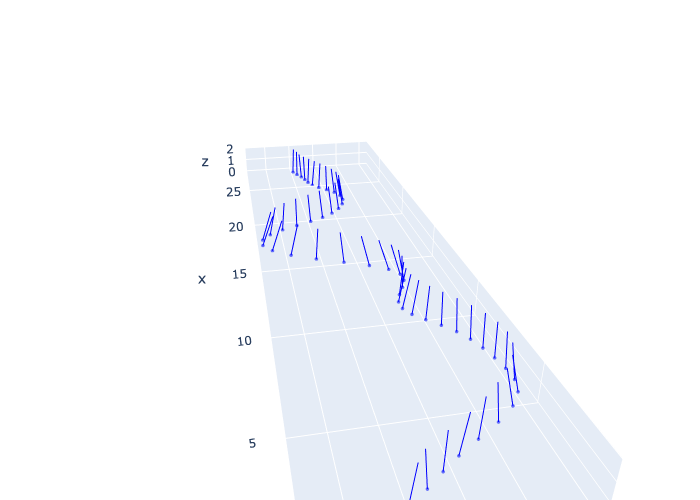

In [25]:
#| caption: Smoothed trajectory with vectored thrust vectors.
#| label: fig:vectored-thrust
X, Y, Z = desired_rn[::5, 0], desired_rn[::5, 1], np.zeros_like(desired_rn[::5, 0])

fig = px.scatter_3d(x=X, y=Y, z=Z)
fig.update_traces(marker=dict(size=2))

# Add thrust vectors as 3d arrows
vectors = vectored_thrust(range(0,250,5))
Tx, Ty, Tz = 0.2*vectors[:, 0], 0.2*vectors[:, 1], 0.2*vectors[:, 2]
for i in range(len(X)):
    fig.add_trace(go.Scatter3d(x=[X[i], X[i] + Tx[i]], y=[Y[i], Y[i] + Ty[i]], z=[Z[i], Z[i] + Tz[i]],
                               mode='lines', line=dict(color='blue', width=2)))

# Set aspect ratio based on W and Height of the map
fig.update_layout(scene=dict(aspectratio=dict(x=1.2, y=H/W, z=2/W)))
fig.update_layout(coloraxis_showscale=False, showlegend=False, margin=dict(l=0, r=0, t=0, b=0))

# Apply the camera settings to the layout
fig.update_layout(scene_camera=dict(eye=dict(x=-1, y=0.2, z=0.5)))

The figure above shows the desired vectored thrust for the optimized trajectory from before. If you execute this section's notebook on colab you would be able to rotate the figure and ascertain that all thrust vectors, even if they are of different lengths, all have exactly the same vertical projection magnitude. This is of course by design, to cancel out gravity in the absence of any requested vertical height changes.

## Combining Feed-forward and Feedback Control

> What we want, in practice!

The virtual thrust vector is an example of a **feed-forward control** strategy. Given the planned trajectory, we *calculate* what we think should happen at every moment. The above could work *if* we are perfectly tracking the planned trajectory. 
However, inevitably small errors will occur, maybe through wind, or model inaccuracies, or small variations in motor thrust. In fact, motors might hit their thrust limits and not be able to deliver the desired thrust completely. More importantly the pitch/roll controller (see below) that is supposed to deliver the thrust vector direction will have a small but consequential lag. All this means that errors *will* occur and we have to deal with them. 

To make this work, we need to incorporate **feedback control** terms that correct for tracking errors. To do so, we add two terms to reduce both positional and velocity errors:

$$
T^n = m \dot v^n_d - m g^n - K_x (X - X_d) - K_v (\dot X - \dot X_d)
$$

This now requires tuning two additional parameters, $K_x$ and $K_v$, for the *proportional* and *derivative* control terms respectively. However, without these terms we have no hopes of staying on track.

The proposed controller is relatively easy to implement in code:

In [26]:
def thrust_controller(k, rn, vn, Kx=0.1, Kv=0.1):
    """Calculate the vectored thrust at timestamp k, adjusted for tracking errors."""
    Tn = vectored_thrust(k)
    Tn -= Kx * (rn - desired_rn[k])
    Tn -= Kv * (vn - desired_vn[k])
    return Tn

# Usage example:
Tn = thrust_controller(0, rn = desired_rn[1], vn = desired_vn[1])
print(f"Tn = {Tn}")

Tn = [ 0.24842873 -0.33362862  9.81      ]


We can set up a small simulation to see how this controller behaves in practice. Note that we ignore the drone rotation here.

In [27]:
K = len(desired_rn)
delta_t = T / K # time between samples
rn = np.zeros((K + 1, 3), float) # allocate storage for time series

# We initialize at the desired position and velocity for k=0:
rn[0] = desired_rn[0]
vn = desired_vn[0].copy()

# integrate forward
for k in range(K):
    # Calculate vectored thrust:
    Tn = thrust_controller(k, rn[k], vn, Kx=0.1, Kv=0.1)

    # DYNAMICS:
    a = Tn / Params.mass + Params.gn
    vn += a * delta_t

    # KINEMATICS:
    rn[k + 1] = rn[k] + vn * delta_t  # integrate position

Plotting the executed trajectory below shows we are almost tracking perfectly now:

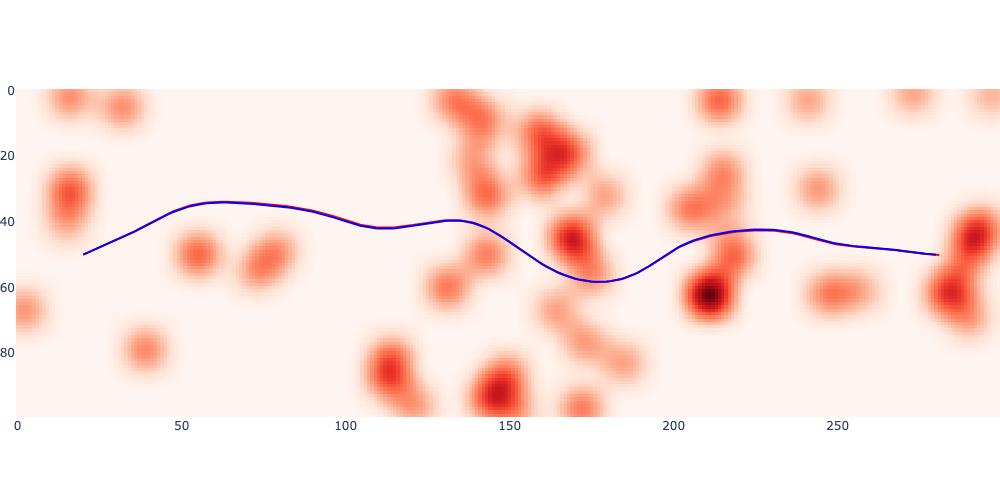

In [28]:
#| caption: 2D trajectory using virtual thrust control, on cost map.
#| label: fig:outer-controller
executed = 10 * rn
fig = px.imshow(blurred, color_continuous_scale='Reds')
fig.add_trace(go.Scatter(x=executed[:,0], y=executed[:,1], mode='lines', line=dict(color='red')))
fig.add_trace(go.Scatter(x=10*desired_rn[:,0], y=10*desired_rn[:,1], mode='lines', line=dict(color='blue')))
fig.update_layout(coloraxis_showscale=False, showlegend=False, width=1000, margin=dict(l=0, r=0, t=0, b=0))

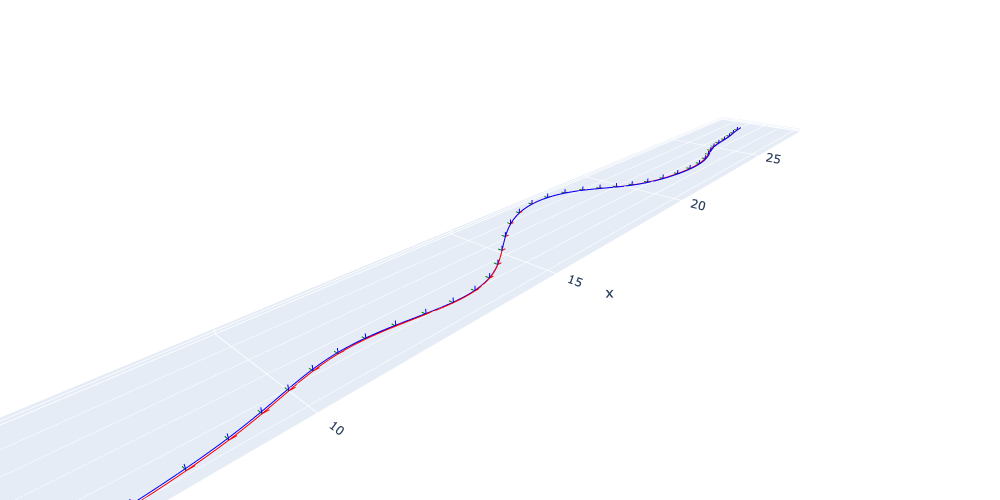

In [29]:
#| caption: 3D trajectory using virtual thrust control.
#| label: fig:outer-controller-3d
nRb = np.tile(np.eye(3),(K,1,1)) # level attitude
fig = drone.show_executed(desired_rn, rn, nRb, K, 1)
fig.update_layout(scene_camera=dict(eye=dict(x=-4, y=-3.5, z=2.5)), width=1000).show()

### Exercises:
- Try setting the proportional and derivative constants $K_x$ and $K_v$ to 0, in isolation or both. Describe to yourself what happens.
- Try setting one or the other to a very high value (1000). What is happening then?

## Vectoring using Fast Rotational Dynamics

While we cannot *instantaneously* produce the desired vectored thrust $T^n$ at any given time, the dynamics of a quadrotor are fast enough that we can get rather close. Remember that the inertial matrix, which resists rotational acceleration, is typically small around the roll and pitch axes. Let us recall the the (approximate) rotational equations of motion:

$$
\dot{R}^n_b	= R^n_b\hat{\omega}^b \\
I \dot{\omega}^b \approx \tau^b
$$

For typical drone configurations the inertial matrix $I$ can be well approximated as $\text{diag}(I_{xy},I_{xy},I_z)$, with the roll-pitch component $I_{xy} < I_z$, the yaw component. Since $I_{xy}$ is small, and we have four powerful motors that can provide differential thrust very quickly, those dynamics are quite fast. Hence, if the attitude $R^n_b$ does not yet align the total thrust $f$ with the desired thrust vector $T^n$, we can quickly make it so by rotating.

To figure out how to make the drone tilt, think of a video game where you are given a two axis controller and the screen displays the *current* orientation of the drone's Z-axis $\hat k^n_b$ and the *desired* thrust vector $T^n$. Your job is to align the two by rolling (rotate around the body X-axis $\hat x^n_b$) and pitching (rotating around the body Y-axis $\hat y^n_n$). Looking at the drone from the outside, in the navigation frame, this will actually be rather hard: typically the controls are fixed to the *body* frame, and at every step you need to perform a mental rotation to find the right action. That is why racing drone pilots much prefer to use a "first person view" or FPV display and controller.

The mathematical equivalent of FPV for a control *algorithm* is to rotate everything into the body frame. Taking the desired thrust vector $T^n$ and multiplying it with the transpose of the attitude $R^n_b$ yields the desired thrust vector $T^b$ in the body frame:

$$
T^b = (R^n_b)^T T^n.
$$

Let us examine each component of this three-vector $T^b$, in the body frame, in turn. Let us name the 3 components $T_F$,  $T_L$, and $T_U$, as we are using the XYZ = Forward-Left-Up convention. Then

- when $T_F$ is *positive*, the desired thrust vector is ahead of the drone, and we should *pitch* forward. Looking from the tip of the Y/Left axis, this corresponds to a counter-clockwise, i.e., positive angular velocity $\omega^b_y>0$ around the Y/Left axis. Likewise, if $T_F$ is *negative*, we should rotate clockwise around the Y-axis, i.e., $\omega^b_y>0$. This inspires a control law for the torque around Y as follows:

    $$
    \tau^b_y = K_F T_F;
    $$

- when $T_L$ is positive, the desired thrust vector is to the left, and we should *roll*. Looking from the tip of the X/Forward axis, this corresponds to a clock-wise, i.e., *negative* angular velocity $\omega^b_x$. This inspires a control law for the torque around X as follows:

    $$
    \tau^b_x = - K_L T_L;
    $$

- the component $T_U$ along the body Up/Z axis is a good approximation of the total thrust we need, and in fact is exactly correct if the thrust vector is already aligned correctly. So, we set

    $$
    f = K_U
    $$

The three control laws above constitute a simple yet effective controller for the drone, with $K_F$ and $K_L$ constants that govern how aggressive the controller is.The torque control laws above correspond to simple **proportional** controllers in control theory, with $-T_F$ and $T_L$ acting as errors to be driven to zero.  The higher the value of $K$, the faster the controller will try to remove those errors, but this could also lead to oscillations and even instabilities. While this is out of scope for the current text, we can obtain a more stable aggressive controller by adding a derivative term as well that is a function of the angular velocity.

In [30]:
def attitude_controller(nT: np.ndarray, nRb: np.ndarray, K: float = 0.1):
    """Calculate the vectored thrust for the desired thrust vector, given in nav frame."""
    # Rotate the desired thrust vector to body frame:
    T_F, T_L, T_U = nRb.T @ nT

    # Calculate the desired roll and pitch torques:
    tau_x = - K * T_L
    tau_y = K * T_F

    # Return alongside total thrust to be commanded:
    return tau_x, tau_y, T_U

nRb = np.eye(3) # Assume the robot is initially level
print(f"vectors[0] = {np.round(vectors[0],2)}")
print(f"control[0] = {np.round(attitude_controller(vectors[0], nRb),4)}")


vectors[0] = [ 0.26 -0.34  9.81]
control[0] = [0.034 0.026 9.81 ]


The example illustrates the behavior: we want to increase the thrust $T_F$ in the X direction to $0.26$, so we will positively *pitch* around the Y-axis: counter-clockwise, pointing the Z-axis forward. Likewise, we want a thrust towards the right ($T^L-0.39$), so we need to roll counter-clockwise, as well, around the Forward/X axis.

### Calculating Motor Thrust Vectors

Creating the requested torque and thrust by the control law is done by adjusting the individual motor thrusts $f_i$. Recalling the force-torque equation in Section 7.2, if we ensure $f_{1} + f_{3} = f_{2} + f_{4}$ we obtain :

$$
\tau_{xy}^b = l \begin{bmatrix}
f_{1}-f_{2}-f_{3}+f_{4}\\
f_{1}+f_{2}-f_{3}-f_{4}\\
0
\end{bmatrix}
$$

The thrust vector magnitude $F^b_z = f$ can be adjusted quickly as well:

$$
f = f_1 + f_2 + f_3 + f_4.
$$

and hence we now have four equations in four unknowns. Solving for the forces yields

$$
f_1 = 0.25 \left( f + \tau_x/l + \tau_y/l \right) \\
f_2 = 0.25 \left( f - \tau_x/l + \tau_y/l \right) \\
f_3 = 0.25 \left( f + \tau_x/l - \tau_y/l \right) \\
f_4 = 0.25 \left( f - \tau_x/l - \tau_y/l \right)
$$

where $l$ is the arm length, and $\tau_x$ and $\tau_y$ are the roll and pitch moment, respectively.




The piece of code below implements this. Although we will not actually use it below, this is what you would have to do on a drone. However, this simplified code does not make any guarantees on not hitting torque limits. Hence, in practice more sophisticated approaches are used return a solution subject to actual control limits, while still trying to deliver some desired torques and/or thrust.

In [31]:
def control_to_motor_speeds(tau_x: float, tau_y: float, f: float, L: float = np.sqrt(0.002)):
    """Convert the desired torques and thrust to motor speeds."""
    # Calculate the motor speeds:
    f_1 = 0.25 * (f + tau_x/L + tau_y/L)
    f_2 = 0.25 * (f - tau_x/L + tau_y/L)
    f_3 = 0.25 * (f + tau_x/L - tau_y/L)
    f_4 = 0.25 * (f - tau_x/L - tau_y/L)

    # Return as a tuple
    return f_1, f_2, f_3, f_4

print(f"motor_speeds[-1] = {control_to_motor_speeds(*attitude_controller(vectors[-1], nRb))}")

motor_speeds[-1] = (2.670523603807631, 2.5035980337877324, 2.401401966212205, 2.234476396192306)


## Code Example

To simulate both controllers working together, we now also need to account for attitude below:

In [32]:
dt = delta_t/10
nRb = np.zeros((K + 1, 3, 3), float) # Now also store attitude

# We again initialize at the desired position and velocity for k=0:
rn[0] = desired_rn[0]
vn = desired_vn[0].copy()

# and have the drone face east (X-axis in navigation frame) initially:
nRb0 = gtsam.Rot3()
nRb[0] = np.eye(3)
wb = np.zeros(3, float) # Initial angular velocity to zero

# integrate forward
for k in range(K):
    # Calculate (corrected) vectored thrust:
    desired_Tn = thrust_controller(k, rn[k], vn, Kx=0.5, Kv=0.01)

    # Inner loop: a fast roll/pitch controller:
    nRb_k = nRb[k].copy()
    for j in range(10):
        # Calculate roll/pitch/thrust controls:
        tau_x, tau_y, T_U = attitude_controller(desired_Tn, nRb_k, K=0.5)
        # clip thrust to be between 0 and 20 Newtons:
        T_U = np.clip(T_U, 0, 20)

        # DYNAMICS: update angular velocity in body frame.
        wb += np.array([tau_x, tau_y, 0]) * dt / Params.I_xy

        # KINEMATICS: update attitude
        delta_R = gtsam.Rot3.Expmap(wb * dt)  # incremental rotation matrix
        nRb_k = nRb_k @ delta_R.matrix()  # integrate attitude
    
    # Translational update:
    actual_Tn = nRb_k @ np.array([0, 0, T_U]) # Not the ideal but the realized Tn
    a = actual_Tn / Params.mass + Params.gn
    vn += a * delta_t
    rn[k + 1] = rn[k] + vn * delta_t  # integrate position

    nRb[k + 1] = nRb_k

Note that in the code we now have an outer and an inner loop. The outer loop is for the "slow" translational dynamics, whereas the inner loop simulates the "fast" attitude dynamics. Such a **cascaded controller** is a typical design choice for drone applications.

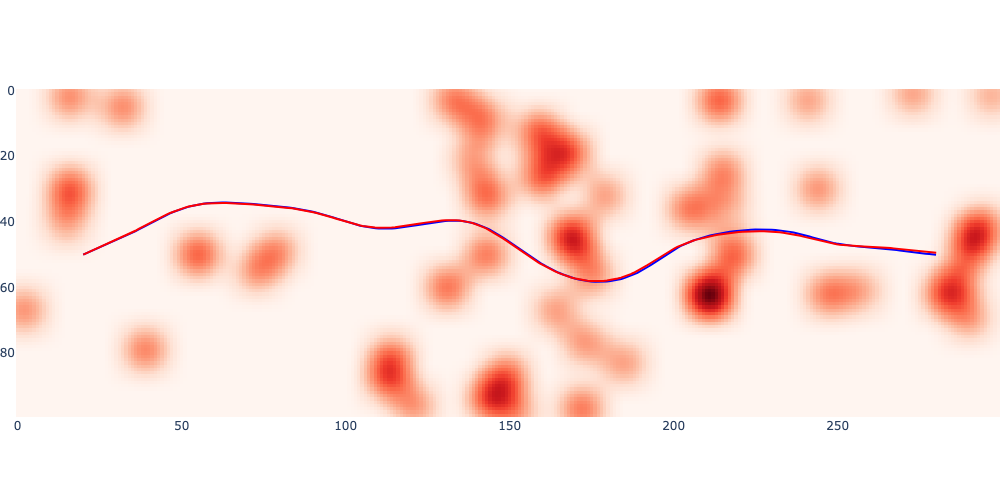

In [33]:
#| caption: 2D trajectory using cascaded controller, on cost map.
#| label: fig:cascaded-control-3d
executed = 10 * rn
fig = px.imshow(blurred, color_continuous_scale='Reds')
fig.add_trace(go.Scatter(x=10*desired_rn[:K,0], y=10*desired_rn[:K,1], mode='lines', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=executed[:K,0], y=executed[:K,1], mode='lines', line=dict(color='red')))
fig.update_layout(coloraxis_showscale=False, showlegend=False, width=1000, margin=dict(l=0, r=0, t=0, b=0))

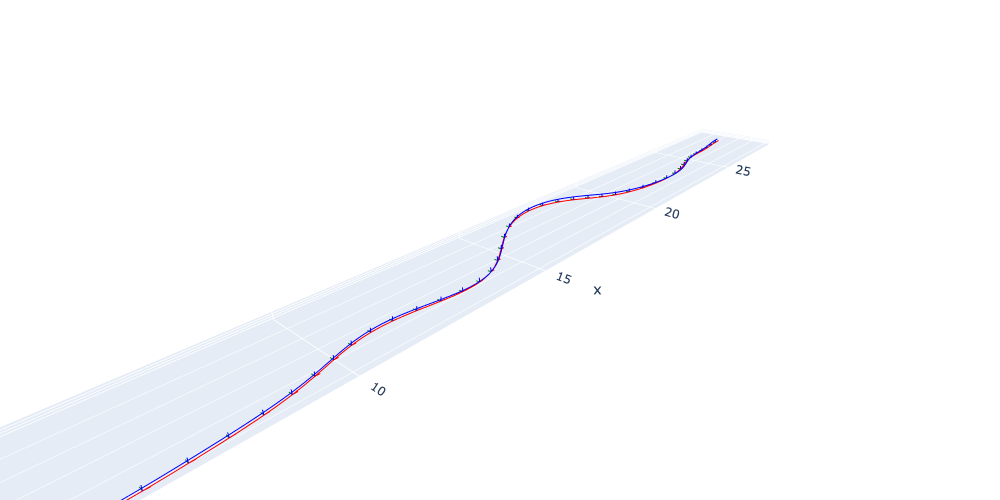

In [34]:
#| caption: 3D trajectory with cascaded controller.
#| label: fig:cascaded-control-3d
fig = drone.show_executed(desired_rn, rn, nRb, K, 1)
fig.update_layout(scene_camera=dict(eye=dict(x=-4, y=-3.5, z=2.5)), width=1000).show()

From the 3D plot above we see that the controller tracks the desired trajectory quite well.

### Exercise

Try tuning up the velocity control constant $K_v$, say to $0.1$. What do you observe. Any theories?

## Planning and Controlling Yaw

Controlling yaw is a crucial aspect in the design of FPV or camera drones, as it enables a drone to point in a specific direction. Since often the drone is equipped with a forward-looking camera, this is obviously useful. 

A simple yaw controller can be implemented to address this, but we will not discuss it in detail here. We would need to also plan the viewing direction of the drone, which involves setting up another objective etc. For example, we could try to ensures that the drone remains pointed at a particular object, e.g., for tasks like aerial photography or inspection.

Yaw control presents more challenges compared to roll/pitch control. This is because yaw involves imparting a moment around the Z/Up axis, which cannot be done using differential force control. Rather, a moment around Z is created by the moments of the rotors themselves: two spin clockwise, and two others counter-clockwise. By making one or the other pair spin faster, a net moment is imparted. However, the moments so produced are much smaller.
